In [9]:
from birdsong_gan.train.train_vqvae import VQVAEModel, TrainingConfig, VQModel

In [11]:
import os
import json 
import numpy as np
import torch

In [3]:
model_dir = "/home/gagan/ek_experiments/vqvae/2024-02-12_08-56-44/"

In [4]:
with open(os.path.join(model_dir, "experiment_config.json"), "r") as f:
    config = json.load(f)

In [5]:
cfg = TrainingConfig()
cfg.from_dict(config)

In [6]:
def load_vqvaemodel_from_checkpoint(config):
    # create model
    vq = VQModel(
        in_channels=1,
        out_channels=1,
        latent_channels=1,
        num_vq_embeddings=config.num_vq_embeddings,
        vq_embed_dim=config.vq_embed_dim,
        layers_per_block=config.layers_per_block,
        sample_size=config.batch_size,
    )
    num_params = vq.num_parameters()
    print(f"Number of parameters in model: {num_params}")

    vq.quantize.legacy = False  # use new quantize function
    vq.quantize.beta = config.vq_beta

    model = VQVAEModel(vq)
    if config.last_checkpoint_path is not None:
        model.load_state_dict(torch.load(config.last_checkpoint_path))
    model.to(config.device)
    return model.eval()

In [7]:
cfg.last_checkpoint_path = os.path.join(model_dir, "model_checkpoint_0_1999.pt")

In [12]:
model = load_vqvaemodel_from_checkpoint(cfg)

Number of parameters in model: 851526


# Load dataset

In [13]:
from datasets import load_from_disk

In [16]:
ds = load_from_disk("/media/gagan/Gagan_external/songbird_data/age_resampled_hfdataset/")
len(ds)

514229

In [17]:
def preprocess_example(x, device: str = "cuda"):
    x = np.array(x["spectrogram"])
    x = np.log1p(x)
    return torch.from_numpy(x).to(torch.float32).to(device)

In [37]:
def chunk_spectrogram(x: torch.Tensor, duration: int = 16) -> torch.Tensor:
    xt = []
    i = 0
    for t in range(x.shape[-1] // duration):
        xt.append(x[:, i : i + duration].unsqueeze(0))
        i += duration
    return torch.stack(xt)

def unchunk_spectrogram(x: torch.Tensor):
    x = x.squeeze()
    return torch.cat([y for y in x], dim=-1)

In [19]:
model.vq.quantize.sane_index_shape = True

# Infer codes

In [29]:
from birdsong_gan.data.data_utils import get_bird_subset, get_age_range_subset, get_all_unique_values, get_random_sample

In [22]:
birds = get_all_unique_values(ds, "bird_name")

In [23]:
birds

['b3g20_tutor',
 'b4g20_tutor',
 'b6r17_tutor',
 'b7r16_tutor',
 'b8r17_tutor',
 'b14r16_tutor',
 'b13r16_tutor',
 'g7r15_tutor',
 'g19r15_tutor',
 'g20r15_tutor',
 'k3r16_tutor',
 'k6r16_tutor',
 'p3r16_tutor',
 'p20r16_tutor',
 'r15s12_tutor',
 'r15y2_tutor',
 'r15y5_tutor',
 'b6r17',
 'b14r16',
 'r15y2',
 'r15y5',
 'b4g20',
 'b8r17',
 'b13r16',
 'g19r15',
 'b7r16',
 'g7r15',
 'g20r15',
 'p3r16',
 'r15s12',
 'k3r16',
 'k6r16',
 'b3g20',
 'p20r16']

In [24]:
subds = get_bird_subset(ds, bird="b7r16")
len(subds)

37711

In [25]:
dph = np.unique(subds["days_post_hatch"])

In [26]:
dph

array([39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90])

In [27]:
subds_day = get_age_range_subset(subds, dph_lower=44, dph_upper=44)
len(subds_day)

343

In [31]:
def encode_sample(sample):
    x = preprocess_example(sample)
    x = chunk_spectrogram(x)
    codes = model.infer_latent_code(x)
    xhat = model.reconstruct(x)
    return codes, xhat, x

In [32]:
c, xhat, x = encode_sample(subds_day[0])

In [36]:
x.shape

torch.Size([6, 1, 129, 16])

In [33]:
c.shape

torch.Size([6, 129, 16])

In [35]:
c[0]

tensor([[22, 52, 58,  ..., 48, 45, 22],
        [40, 19, 16,  ..., 19, 17, 63],
        [46, 11,  1,  ..., 58, 26, 59],
        ...,
        [43, 37, 35,  ..., 34, 16, 34],
        [59,  1, 29,  ..., 19, 19, 19],
        [22, 22, 44,  ..., 24, 25, 22]], device='cuda:0')

In [44]:
129 * 16 * 6

12384

In [34]:
xhat.shape

torch.Size([6, 1, 129, 16])

In [38]:
from birdsong_gan.utils.audio_utils import plot_spectrogram

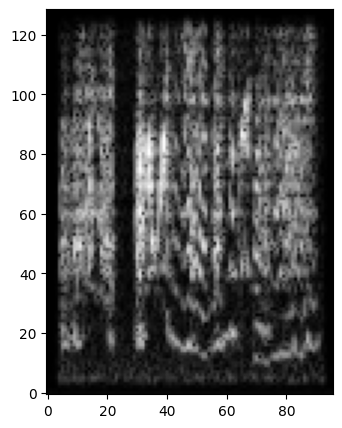

In [42]:
_ = plot_spectrogram(unchunk_spectrogram(x).cpu().numpy(), figsize=(12,5))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

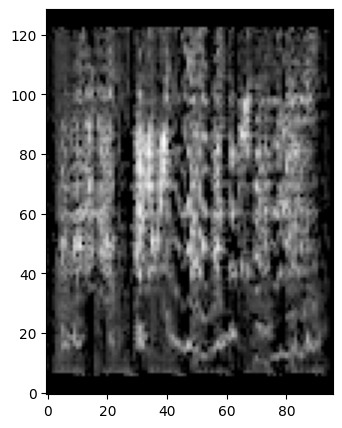

In [43]:
_ = plot_spectrogram(unchunk_spectrogram(xhat).cpu().numpy(), figsize=(12,5))